In [51]:
import numpy as np
import sys
from scipy.stats import entropy
from scipy.special import rel_entr
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import torch,torch.optim, torch.nn
import sklearn.datasets

In [64]:
# Note: binary search works because the perplexity increases monotonically with the variance

def get_p_scores(X, perp = 30):
    """
    This function computes and returns the joined probability distribution for the high dimensional
    datapoints.
    """
    N = len(X)
    
    target_h = np.log2(perp)
    
    betas_max = np.ones(N)
    betas_min = np.ones(N)
    betas = np.ones(N)
    
    betas_max[:] = 10000
    betas_min[:] = 0.1
    
    betas[:] = (betas_max + betas_min) / 2
     
    conditionals = get_conditionals(X, betas)
    actual_h = entropy(conditionals, base = 2, axis = 1)
    
    tolerance = 1e-5
    
    while np.sum(np.abs(actual_h - target_h) > tolerance) > 0:
        
        greater = (actual_h - target_h) > tolerance
        
        betas_max[greater] = betas[greater]
        
        lesser = (actual_h - target_h) < tolerance
        
        betas_min[lesser] = betas[lesser]
        
        need_change = np.abs(actual_h - target_h) > tolerance
        
        betas[need_change] = (betas_max[need_change] + betas_min[need_change]) / 2
        
        conditionals = get_conditionals(X, betas)
        
        actual_h = entropy(conditionals, base = 2, axis = 1)

    probs_sym = (conditionals.T + conditionals) / (2 * len(X))

    return probs_sym

def get_conditionals(X, betas):
    """
    This function computes and returns the conditional probability distribution for the high dimensional
    datapoints.
    """
    dists = (cdist(X, X)**2) / betas[:, None]
    
    exp = np.exp(-dists)
    np.fill_diagonal(exp, 0)
    
    row_sums = np.sum(exp, axis = 1)[:, None]
    exp /= row_sums
    
    return exp

def compute_cost(p_scores, q_scores):
    """
    This function computes the KL-divergence between the joined probability distribution for the high dimensional
    datapoints (fixed) and the joined probability distribution for the low dimensional datapoints (to be learned).
    """
    eps=1e-7
    kl_loss = torch.nn.KLDivLoss(reduction = "sum", log_target = True)
    return kl_loss(torch.log(q_scores + eps), torch.log(p_scores + eps))

def get_q_scores(Y):
    """
    This function computes and returns the joined probability distribution for the low dimensional
    datapoints.
    """
    q_scores = (torch.cdist(Y, Y)**2 + 1) **-1
    q_scores.fill_diagonal_(0)
            
    q_scores /= q_scores.sum()
    
    return q_scores

def init_y(X, method = "PCA"):
    """
    This function computes and returns initial values for the low dimensional datapoints.
    The recommended method for computing these values is 'PCA'.
    """
    if method == "PCA":
        return torch.tensor(PCA(n_components = 2).fit_transform(X))
    elif method == "random":
        return torch.tensor(np.random.normal(size = (len(X), 2), scale = 1.0))
    else: 
        raise ValueError("unknown method")

In [93]:
dataset = sklearn.datasets.load_digits()

X = dataset['data']
T = dataset['target']
R = np.random.mtrand.RandomState(0).permutation(len(X))[:1100]
X = X[R]
T = T[R]

# p_scores = torch.tensor(get_p_scores(X, 30))
# y = init_y(X)
# y.requires_grad_(True)

In [94]:
def train(p_scores, y, eg_factor = 4, n_iter = 1000):
    
    """
    This function iteratively updates the low dimensional representation of our data
    by applying gradient descent.
    """
    
    optimizer = torch.optim.SGD((y,), lr=200, momentum=0.95)
    
    for i in range(n_iter):
        
        q_scores = get_q_scores(y)
        
        optimizer.zero_grad()
        
        if i < 50:
            J = compute_cost(p_scores * eg_factor, q_scores)
        else: 
            J = compute_cost(p_scores, q_scores)
            
        if i != 0 and i % 100 == 0:
            print(f"KL-divergence after {i} iterations: {J.data.numpy()}")
        
        J.backward()
        optimizer.step()
        
    return y




# train(p_scores, y, eg_factor = 4)

In [100]:
def compare_perplexities(X, perps):
    
    results = []
    for i, perp in enumerate(perps):
        
        print(f"\nStarting training for perplexity value {perp}")
        p_scores = torch.tensor(get_p_scores(X, perp))
        y = init_y(X)
        y.requires_grad_(True)
        results.append((train(p_scores, y).detach().numpy(), perp))
        
    return results


results = compare_perplexities(X, [5, 30, 70])   
    


Starting training for perplexity value 5
KL-divergence after 100 iterations: 0.9122771949619788
KL-divergence after 200 iterations: 0.8395432288564756
KL-divergence after 300 iterations: 0.815143417614851
KL-divergence after 400 iterations: 0.7999680615477699
KL-divergence after 500 iterations: 0.7851638637474707
KL-divergence after 600 iterations: 0.7723086165304291
KL-divergence after 700 iterations: 0.7615637378738569
KL-divergence after 800 iterations: 0.7508949319533135
KL-divergence after 900 iterations: 0.7441151943345358

Starting training for perplexity value 30
KL-divergence after 100 iterations: 0.6838067081231525
KL-divergence after 200 iterations: 0.6172858052078283
KL-divergence after 300 iterations: 0.5927453803146533
KL-divergence after 400 iterations: 0.5809158836985457
KL-divergence after 500 iterations: 0.5740707983827512
KL-divergence after 600 iterations: 0.567691324555572
KL-divergence after 700 iterations: 0.5642529866002381
KL-divergence after 800 iterations: 0

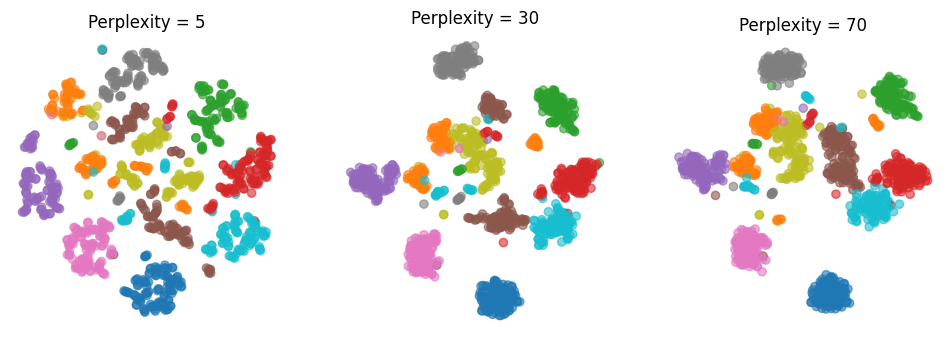

In [102]:
def visualize(embeddings):
    plt.figure(figsize = (12,8))
    
    for i, e in enumerate(embeddings):
        y, p = e
        
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_aspect("equal")
        ax.set_title(f"Perplexity = {p}")
        ax.scatter(y[:,0], y[:,1], c = T, cmap = "tab10", alpha = 0.6)
        
    plt.show()
    
visualize(results)

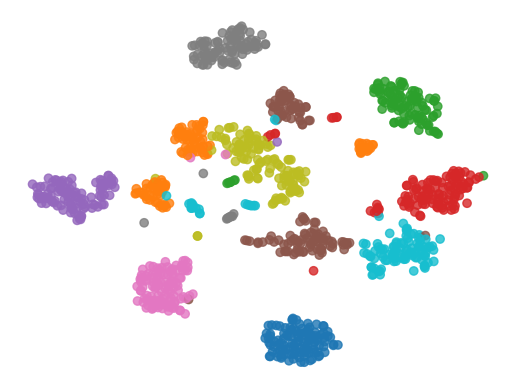

In [92]:
plt.axis("off")
y = results[1]
plt.scatter(y.detach().numpy()[:,0], y.detach().numpy()[:,1], c = T, cmap = "tab10", alpha = 0.8)

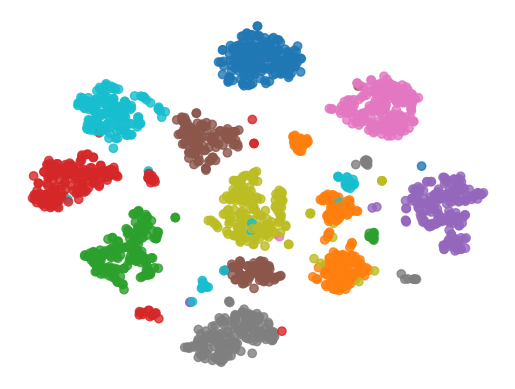

In [55]:
from matplotlib import pyplot as plt

# ax = fig.add_subplot(111)
plt.axis("off")

plt.scatter(y.detach().numpy()[:,0], y.detach().numpy()[:,1], c = T, cmap = "tab10", alpha = 0.8)
# plt.savefig("T-SNE.pdf")

In [15]:
# TODO (Code):
# - demonstrate different hyperparameter choices
# - more datasets? 

In [9]:
from sklearn.manifold import TSNE

model = TSNE(method = "exact",)
embedded = model.fit_transform(X)

/home/manuel/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/manuel/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


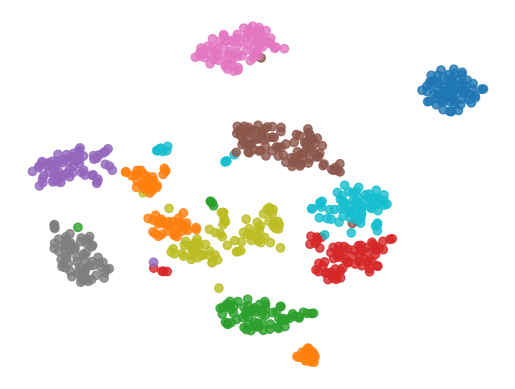

In [10]:
plt.axis("off")

plt.scatter(embedded[:,0], embedded[:,1], c = T, cmap = "tab10", alpha = 0.8)